In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#define time range
t_start = 7.52
duration = 0.2
t_end = t_start + duration
shape_orig = (720, 1280)

In [3]:
events_raw = tum_dset.load_events_time(path + "data/tum-vie-3d/mocap-3d-trans-events_right.h5", t_start, t_end)

C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:38: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]
C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]


6826126 events


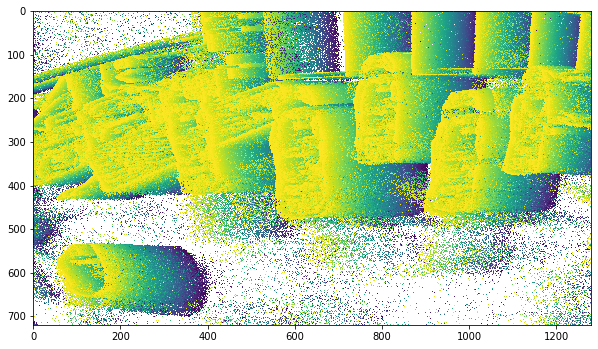

In [4]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

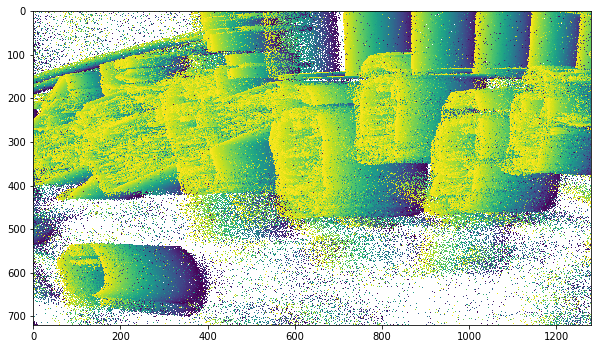

In [5]:
events_ref = flt.filter_refract(events_raw, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

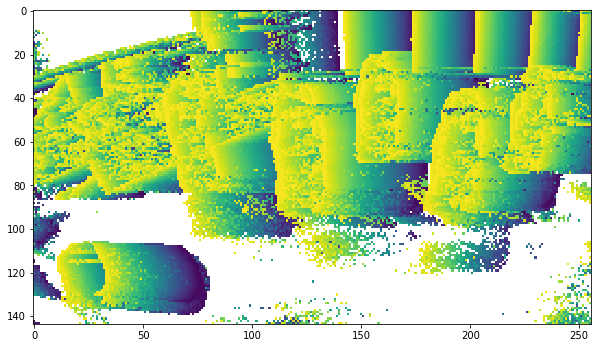

In [6]:
events, shape = flt.filter_conv(events_ref, shape_orig)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [7]:
# events = flt.filter_refract(events, 0.1)

In [8]:
poses = tum_dset.load_poses(path + "data/tum-vie-3d/mocap_data.txt")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")

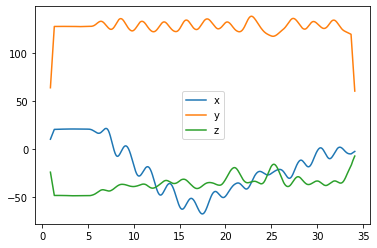

In [9]:
plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
plt.legend()

In [10]:
time_d = td2d.TimeDifference2d(shape, events, poses)

(2, 3981)


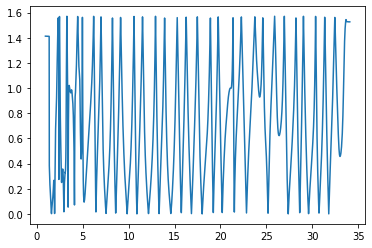

In [11]:
# test = time_d.directions
# test_c = np.convolve(test[:,1], np.ones(500), mode="same")
# plt.plot(test_c)
# time_d.directions[:,1] = test_c
test = np.mod(time_d.directions[:,1], 2*np.pi)
plt.plot(time_d.directions[:,0], test)
time_d.directions[:,1] = test

In [12]:
final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=9, delay=0.18, avg_n=20, std_mul=0.005)

100%|████████████████████████████████████████████████████████████████████████| 135021/135021 [1:08:46<00:00, 32.72it/s]


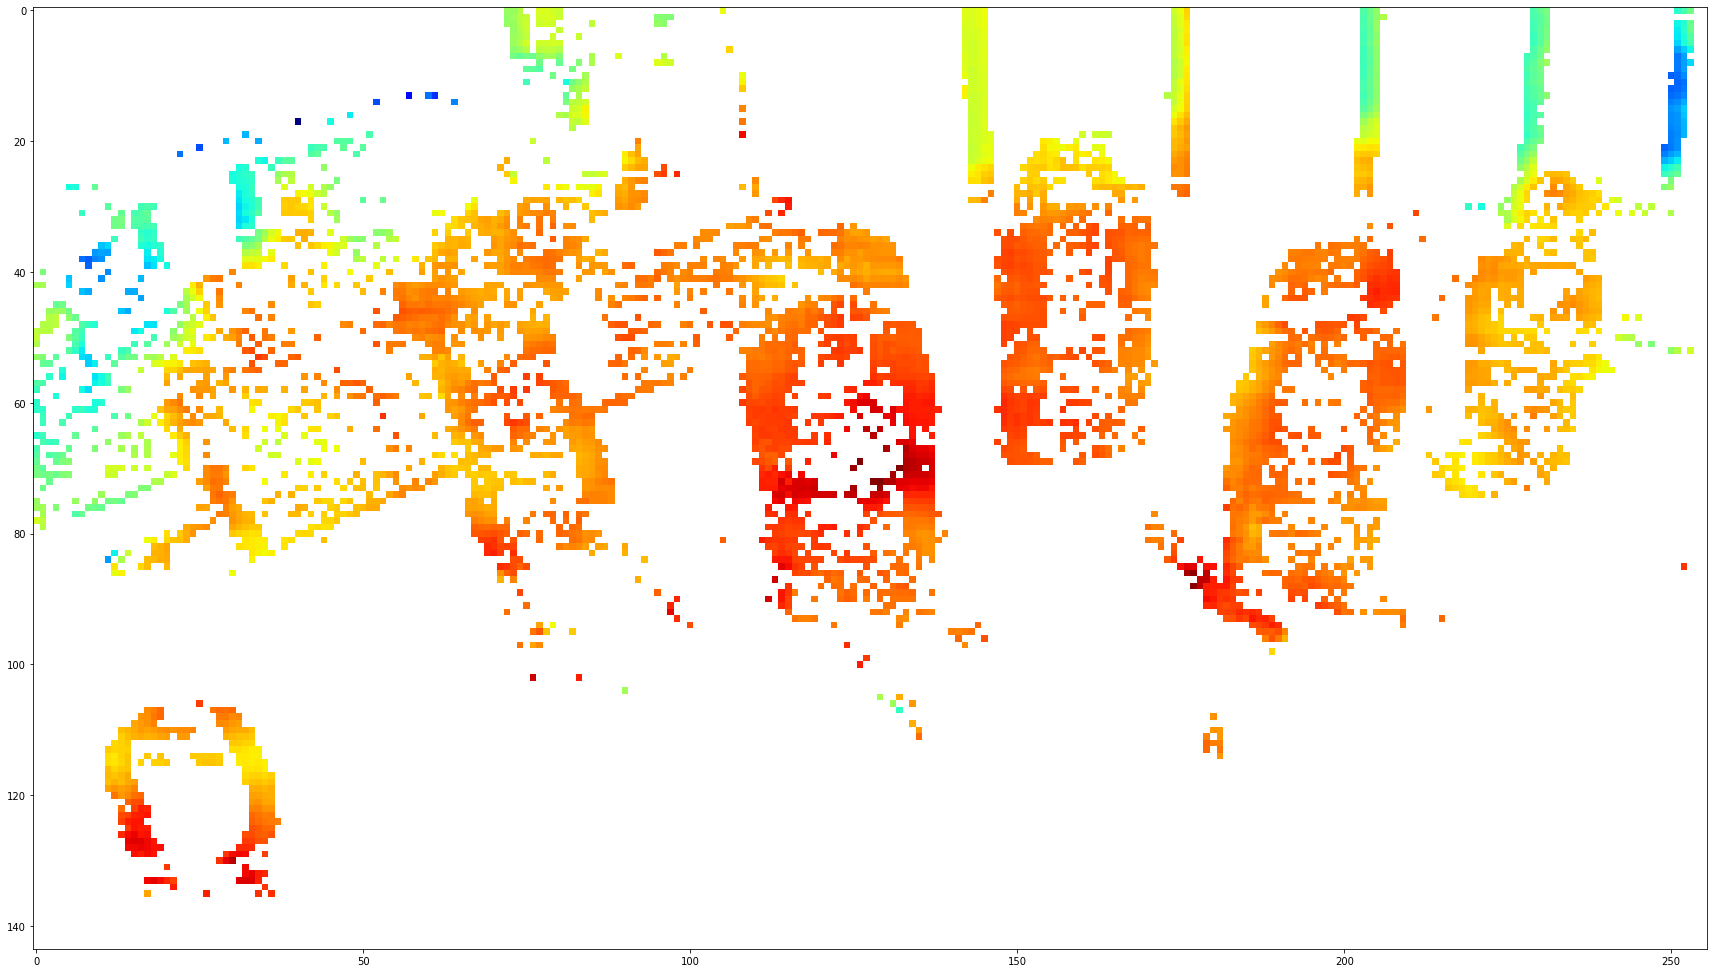

In [13]:
%matplotlib inline
plt.figure(figsize=(30, 30))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

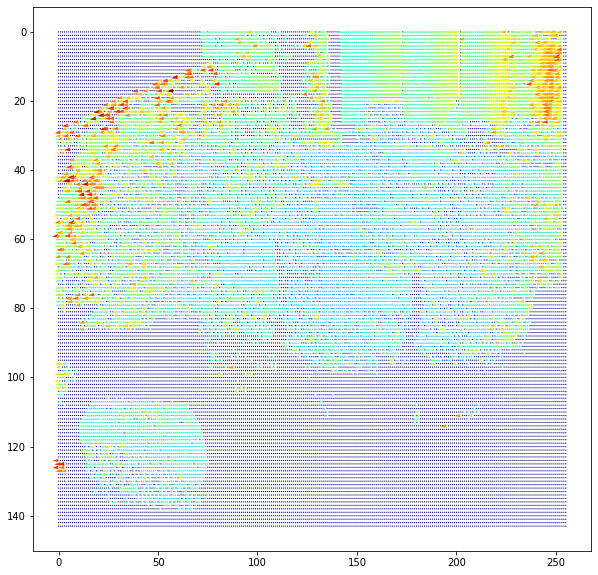

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, U, scale =1, cmap="jet_r")
plt.gca().invert_yaxis()

In [15]:
u = np.divide(1.0, final_td_m, where=final_td!=0.0)
d = td.v2depth(u, 2.0, 200.0)

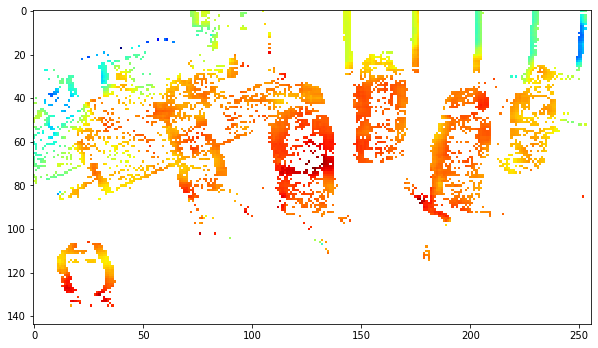

In [16]:
plt.figure(figsize=(10, 10))
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

In [17]:
%matplotlib qt
vis.visualize3d(d)